# Navie Bayesian Model with Tf-idf Features

Navie Bayesian model with TF-IDF features one of the most basic and traditional approach that has been widely used to do text classification. Here, I use it to set up the baseline for the Popcorn Movie Review Sentiment Analysis, before using the RNN models.

## 1. Load Data

Before running this notebook, all the text data preprocessing has been done by running **prep_text_for_tfidf.py**, and the cleaned text has been saved in the pickle file "***docs***" (for labeledTrainData.tsv and unlabeledTrainData.tsv) and "***test_docs***" (for testData.tsv).

In [1]:
from utils import load_data
import pickle 
import pandas as pd

In [2]:
train, test = load_data(return_unlabeled=False)
y_train = train["sentiment"]

Due to the data leakage issue in the test set, the label of sentiment could be derived from "id" directly, and it will be used to evaluate the model performance later in this notebook.

In [3]:
test["sentiment"] = test["id"].map(lambda x: 1 if int(x.strip('"').split("_")[1]) > 5 else 0)
y_test = test["sentiment"]

In [4]:
with open("docs", "rb") as fp:
    docs = pickle.load(fp)
    
fp.close()

with open("test_docs", "rb") as fp:
    test_docs = pickle.load(fp)
fp.close()

## 2. Feature Extraction and Modeling

There are two ways to do feature extraction and modeling with sklearn.The most basic way is to do feature extraction and modeling step by step. However, with sklearn's **Pipeline( )** function, we could do them in one-shot.

###  1) Implementation with Pipeline

In [5]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve

In [6]:
tfidf = TfidfVectorizer(max_features=1000, ngram_range=(1, 2))
nb_pipe = Pipeline([
    ("tfidf", tfidf),
    ("NB", MultinomialNB())
])

In [7]:
nb_pipe.fit(docs[:25000], y_train)

Pipeline(memory=None,
     steps=[('tfidf', TfidfVectorizer(analyzer=u'word', binary=False, decode_error=u'strict',
        dtype=<type 'numpy.int64'>, encoding=u'utf-8', input=u'content',
        lowercase=True, max_df=1.0, max_features=1000, min_df=1,
        ngram_range=(1, 2), norm=u'l2', preprocessor=None, smooth_idf=Tru...True,
        vocabulary=None)), ('NB', MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))])

In [8]:
y_pred_pipe = nb_pipe.predict(test_docs)

In [9]:
print("The accuracy score is %.4f." % accuracy_score(y_test, y_pred_pipe))

The accuracy score is 0.8318.


## 2) Implement by step by step incorportating data from unlabeled data

With Pipeline(), during training, the TfidfVectorizer is fit and transform the training data with labeled only. Here "fit" means learning the vocabulary. In order to incorporate the unlabeledTrainData.tsv (which includes in docs[25000:], we need to implement the flow step by step.

In [10]:
tfidf = TfidfVectorizer(max_features=1000, ngram_range=(1, 2))
nb = MultinomialNB()

In [11]:
tfidf.fit(docs)

TfidfVectorizer(analyzer=u'word', binary=False, decode_error=u'strict',
        dtype=<type 'numpy.int64'>, encoding=u'utf-8', input=u'content',
        lowercase=True, max_df=1.0, max_features=1000, min_df=1,
        ngram_range=(1, 2), norm=u'l2', preprocessor=None, smooth_idf=True,
        stop_words=None, strip_accents=None, sublinear_tf=False,
        token_pattern=u'(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
        vocabulary=None)

In [12]:
X_train = tfidf.transform(docs[:25000])
X_test = tfidf.transform(test_docs)

In [13]:
nb.fit(X_train, y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [14]:
y_pred = nb.predict(X_test)

In [15]:
print("The accuracy score after incorprating unlabeledTrainData.tsv is %.4f." %accuracy_score(y_test, y_pred))

The accuracy score after incorprating unlabeledTrainData.tsv is 0.8338.


** The accuracy has been improved a little bit as compared. But that's good enough. **

## 3. Probability Calibration and Model Evaluation

Since in the original Kaggle competition, the AUC is used to evaluate the prediction performance. However, Naive Bayes model doesn't output the meaningful probability of each class, we need to use sklearn's [CalibratedClassifierCV()](http://scikit-learn.org/stable/modules/generated/sklearn.calibration.CalibratedClassifierCV.html) to get the propriate probabilities.

In [16]:
from sklearn.calibration import CalibratedClassifierCV
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [17]:
clf = CalibratedClassifierCV(nb, cv = 5)
clf.fit(X_train, y_train)

CalibratedClassifierCV(base_estimator=MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True),
            cv=5, method='sigmoid')

In [18]:
y_pred_proba_c = clf.predict_proba(X_test)[:, 1]

In [19]:
print("The AUC score is %.4f." % roc_auc_score(y_test, y_pred_proba_c))

The AUC score is 0.9124.


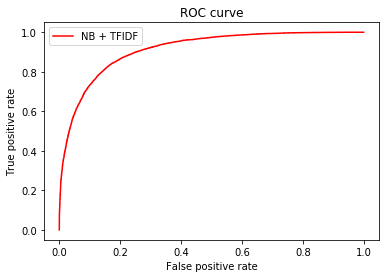

In [20]:
fpr, tpr, _ = roc_curve(y_test, y_pred_proba_c)

plt.plot(fpr, tpr, 'r-', label = "NB + TFIDF")
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.title("ROC curve")
plt.legend()